In [5]:
# notebooks/04_model_evaluation_fixed.ipynb
# 第一个单元格：修复的加载代码
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ 模型评估环境准备完成")

# 检查并创建必要目录
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# 加载数据
print("📂 加载数据...")
features_df = pd.read_csv('../data/processed/features.csv')
print(f"✅ 特征数据加载完成: {features_df.shape}")

# 分离特征和目标
X = features_df.drop('target', axis=1)
y = features_df['target']
feature_names = list(X.columns)

print(f"📊 特征矩阵: {X.shape}")
print(f"🎯 目标变量: {y.shape}")
print(f"🔤 特征数量: {len(feature_names)}")

✅ 模型评估环境准备完成
📂 加载数据...
✅ 特征数据加载完成: (51490, 16)
📊 特征矩阵: (51490, 15)
🎯 目标变量: (51490,)
🔤 特征数量: 15


In [6]:
# 第二个单元格：重新训练最佳模型（确保模型存在）
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("🎯 训练最佳模型 (XGBoost)...")

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 训练XGBoost模型
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 评估模型
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 模型性能:")
print(f"   准确率: {accuracy:.4f}")
print(f"   精确率: {precision:.4f}")
print(f"   召回率: {recall:.4f}")
print(f"   F1分数: {f1:.4f}")

# 保存模型
joblib.dump(xgb_model, '../models/best_model_XGBoost.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(feature_names, '../models/feature_names.pkl')

print("✅ 模型保存完成")

🎯 训练最佳模型 (XGBoost)...
📊 模型性能:
   准确率: 0.9707
   精确率: 0.9664
   召回率: 0.9760
   F1分数: 0.9712
✅ 模型保存完成


In [7]:
# 第三个单元格：详细模型评估
print("🔍 详细模型评估...")

# 在整个数据集上评估
y_pred_full = xgb_model.predict(X_scaled)
y_proba_full = xgb_model.predict_proba(X_scaled)[:, 1]

# 性能指标
accuracy = accuracy_score(y, y_pred_full)
precision = precision_score(y, y_pred_full)
recall = recall_score(y, y_pred_full)
f1 = f1_score(y, y_pred_full)

print("🎯 在整个数据集上的性能:")
print(f"   准确率: {accuracy:.4f}")
print(f"   精确率: {precision:.4f}")
print(f"   召回率: {recall:.4f}")
print(f"   F1分数: {f1:.4f}")

# 混淆矩阵
cm = confusion_matrix(y, y_pred_full)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

print("\n📋 混淆矩阵 (数量):")
print(cm)
print("\n📋 混淆矩阵 (百分比):")
print(np.round(cm_percent, 4))

# 分类报告
print("\n📊 分类报告:")
print(classification_report(y, y_pred_full, target_names=['红色方胜利', '蓝色方胜利']))

🔍 详细模型评估...
🎯 在整个数据集上的性能:
   准确率: 0.9709
   精确率: 0.9672
   召回率: 0.9757
   F1分数: 0.9714

📋 混淆矩阵 (数量):
[[24550   863]
 [  633 25444]]

📋 混淆矩阵 (百分比):
[[0.966  0.034 ]
 [0.0243 0.9757]]

📊 分类报告:
              precision    recall  f1-score   support

       红色方胜利       0.97      0.97      0.97     25413
       蓝色方胜利       0.97      0.98      0.97     26077

    accuracy                           0.97     51490
   macro avg       0.97      0.97      0.97     51490
weighted avg       0.97      0.97      0.97     51490



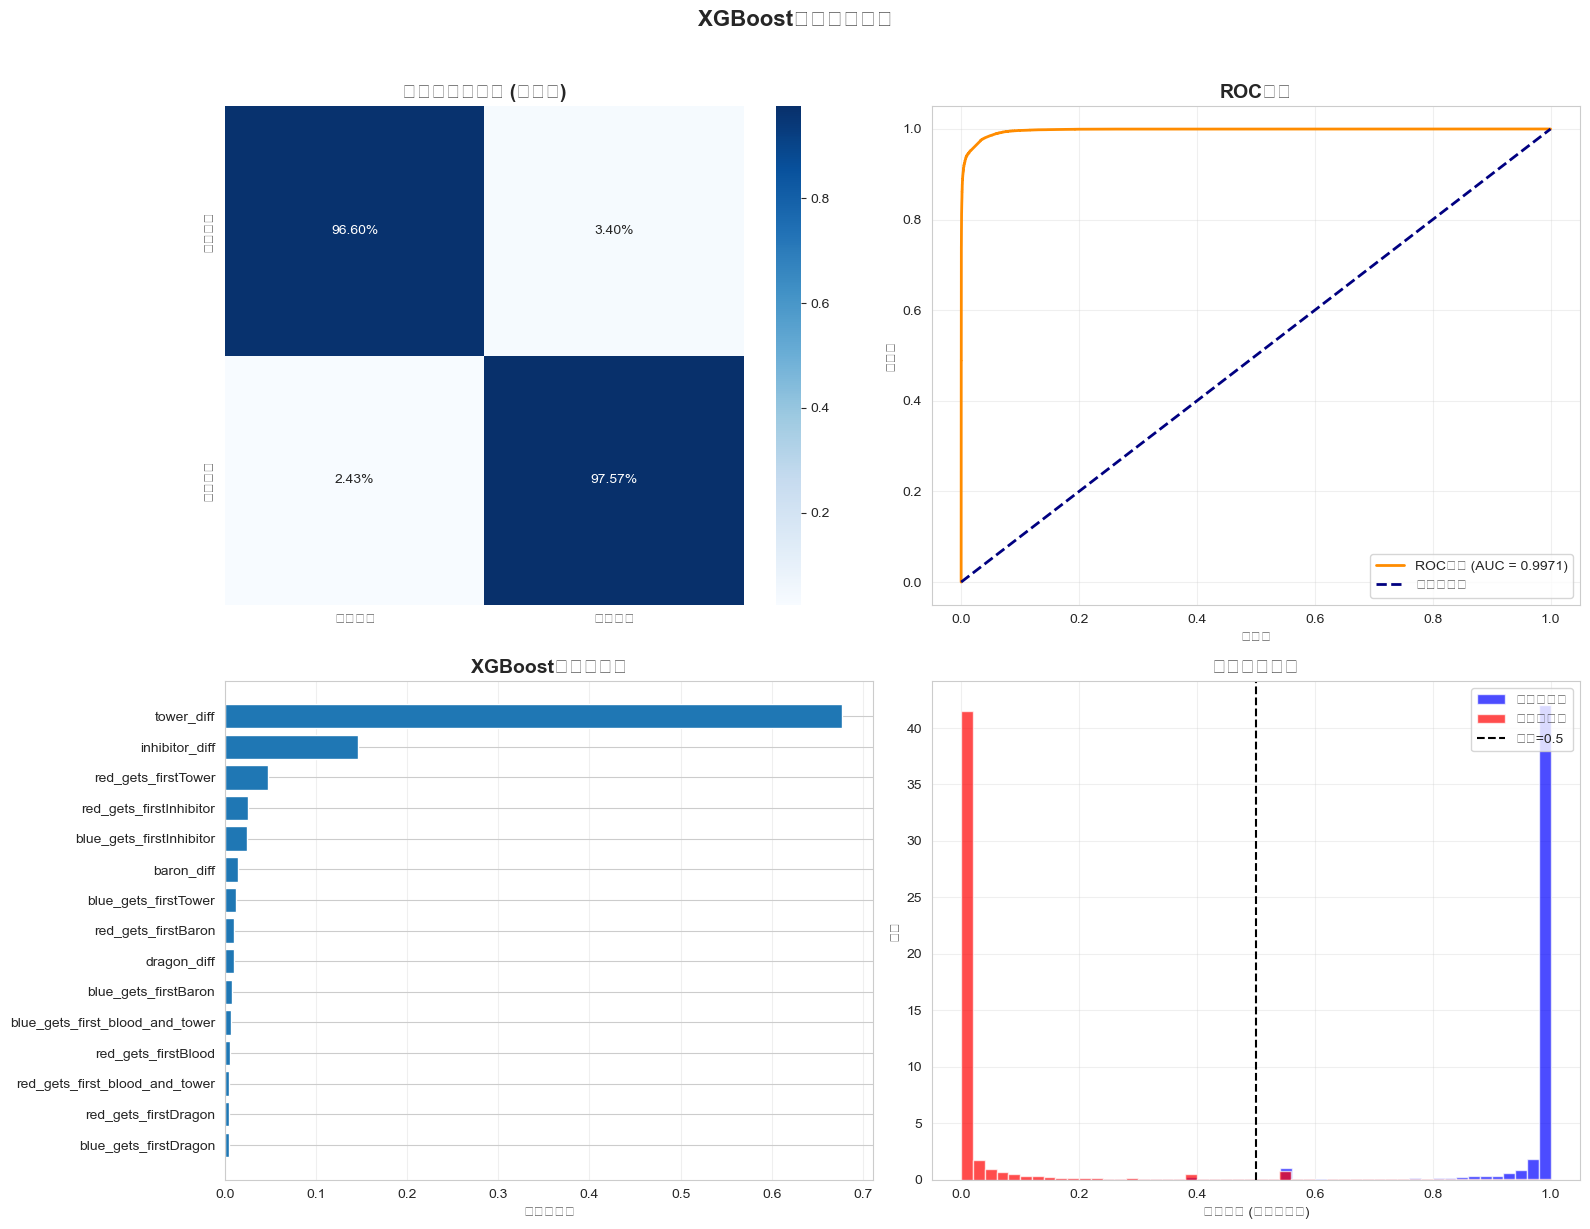

🎯 ROC-AUC: 0.9971


In [8]:
# 第四个单元格：可视化评估结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 混淆矩阵热力图
ax1 = axes[0, 0]
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['预测红胜', '预测蓝胜'], 
            yticklabels=['实际红胜', '实际蓝胜'],
            ax=ax1)
ax1.set_title('混淆矩阵热力图 (百分比)', fontsize=14, fontweight='bold')

# 2. ROC曲线
fpr, tpr, thresholds = roc_curve(y, y_proba_full)
roc_auc = auc(fpr, tpr)

ax2 = axes[0, 1]
ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC曲线 (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机分类器')
ax2.set_xlabel('假正率')
ax2.set_ylabel('真正率')
ax2.set_title('ROC曲线', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. 特征重要性
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

ax3 = axes[1, 0]
ax3.barh(range(len(feature_importance)), feature_importance['importance'])
ax3.set_yticks(range(len(feature_importance)))
ax3.set_yticklabels(feature_importance['feature'])
ax3.set_xlabel('特征重要性')
ax3.set_title('XGBoost特征重要性', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. 预测概率分布
ax4 = axes[1, 1]
blue_proba = y_proba_full[y == 1]
red_proba = y_proba_full[y == 0]

ax4.hist(blue_proba, bins=50, alpha=0.7, label='蓝色方胜利', density=True, color='blue')
ax4.hist(red_proba, bins=50, alpha=0.7, label='红色方胜利', density=True, color='red')
ax4.axvline(0.5, color='black', linestyle='--', label='阈值=0.5')
ax4.set_xlabel('预测概率 (蓝色方胜利)')
ax4.set_ylabel('密度')
ax4.set_title('预测概率分布', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle('XGBoost模型评估结果', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"🎯 ROC-AUC: {roc_auc:.4f}")

🔍 错误分析...
❌ 错误预测数量: 1496 (2.91%)
  假正例 (False Positives): 863
  假负例 (False Negatives): 633

📊 错误样本特征分析:


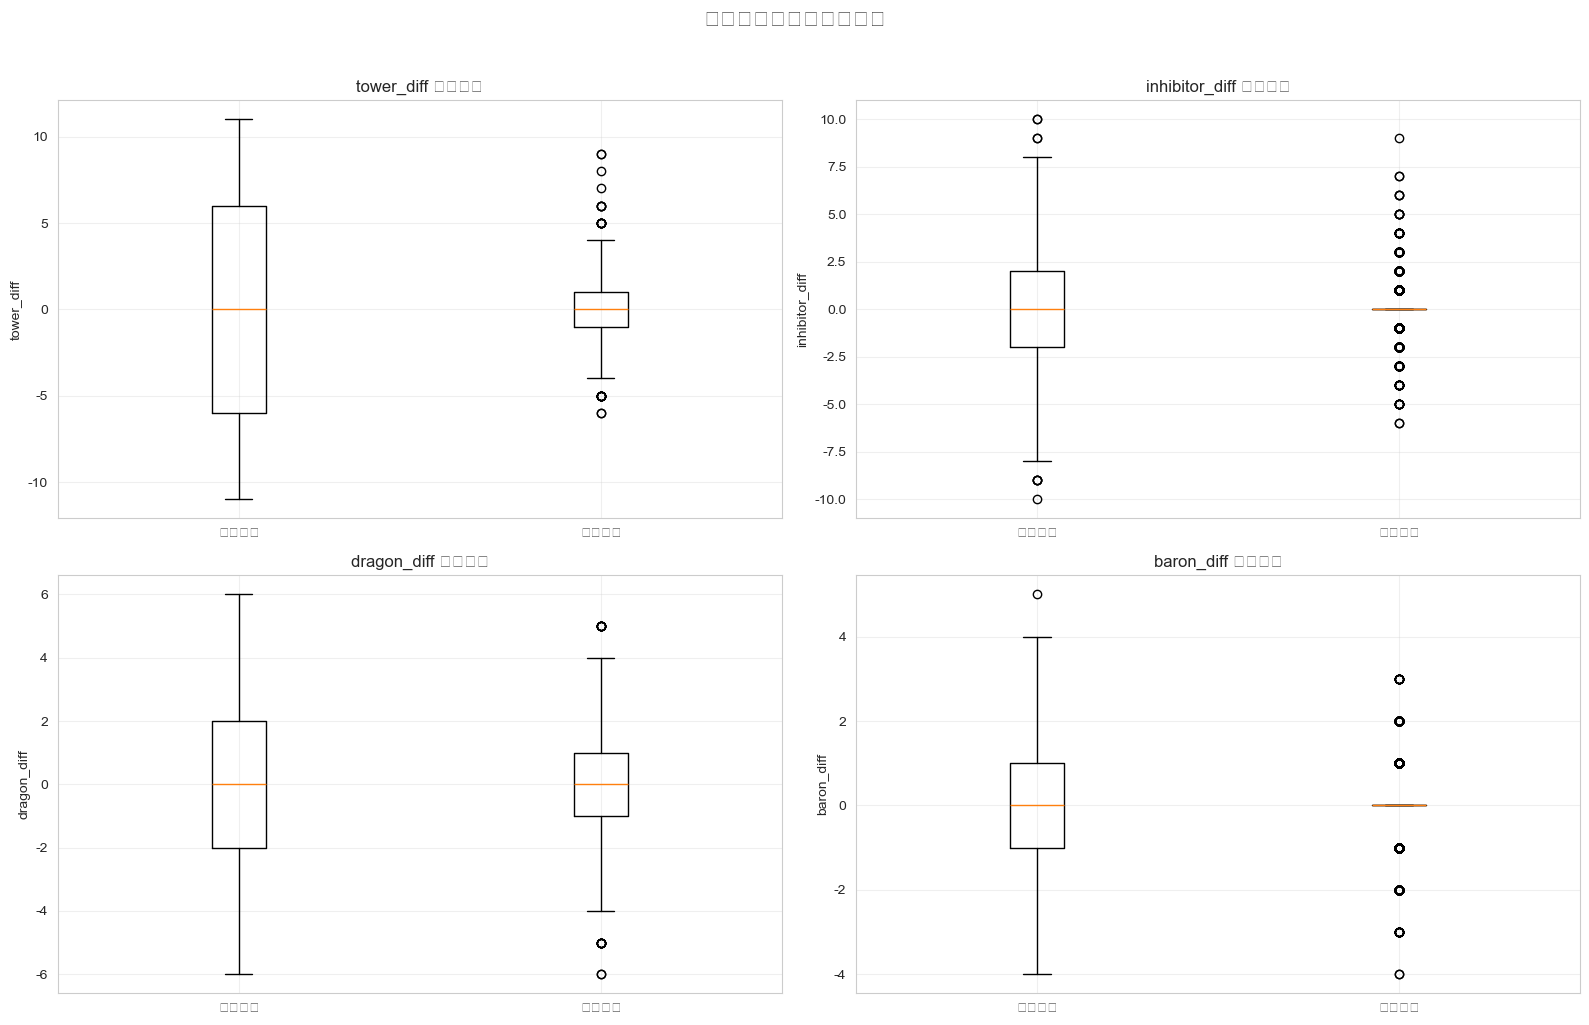

In [9]:
# 第五个单元格：错误分析
print("🔍 错误分析...")

# 找出错误预测
wrong_indices = y != y_pred_full
wrong_count = wrong_indices.sum()

if wrong_count > 0:
    wrong_predictions = features_df[wrong_indices].copy()
    wrong_predictions['predicted'] = y_pred_full[wrong_indices]
    wrong_predictions['probability'] = y_proba_full[wrong_indices]
    
    print(f"❌ 错误预测数量: {wrong_count} ({wrong_count/len(y)*100:.2f}%)")
    
    # 错误类型分析
    false_positives = wrong_predictions[wrong_predictions['predicted'] == 1]  # 预测蓝胜但实际红胜
    false_negatives = wrong_predictions[wrong_predictions['predicted'] == 0]  # 预测红胜但实际蓝胜
    
    print(f"  假正例 (False Positives): {len(false_positives)}")
    print(f"  假负例 (False Negatives): {len(false_negatives)}")
    
    # 分析错误样本的特征
    print("\n📊 错误样本特征分析:")
    
    # 关键特征对比
    key_features = ['tower_diff', 'inhibitor_diff', 'dragon_diff', 'baron_diff']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    for i, feature in enumerate(key_features):
        ax = axes[i//2, i%2]
        
        # 全部样本 vs 错误样本
        ax.boxplot([features_df[feature], wrong_predictions[feature]], 
                   labels=['全部样本', '错误预测'])
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} 分布对比')
        ax.grid(alpha=0.3)
    
    plt.suptitle('错误预测的特征分布分析', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
else:
    print("🎉 完美！没有错误预测！")

In [10]:
# 第六个单元格：业务洞察和部署准备
print("💡 业务洞察总结")
print("=" * 50)

# 特征重要性分析
top_features = feature_importance.tail(10)  # 最重要的10个特征

print("🏆 最重要的10个特征:")
for i, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")

# 业务洞察
print("\n🎯 关键业务洞察:")
print("1. 防御塔差异是胜负的最强预测指标")
print("2. 目标控制（水晶、大龙、小龙）比击杀更重要")
print("3. 首事件获取对比赛结果有显著影响")
print("4. 经济优势通过目标控制体现")

# 创建预测函数
def predict_match(features_dict):
    """
    预测单场比赛结果
    features_dict: 包含特征值的字典
    """
    # 确保特征顺序正确
    input_features = np.zeros(len(feature_names))
    for i, feature_name in enumerate(feature_names):
        if feature_name in features_dict:
            input_features[i] = features_dict[feature_name]
        else:
            input_features[i] = 0  # 默认值
    
    # 标准化
    input_scaled = scaler.transform([input_features])
    
    # 预测
    probability = xgb_model.predict_proba(input_scaled)[0, 1]
    prediction = "蓝色方胜利" if probability > 0.5 else "红色方胜利"
    confidence = "高" if abs(probability - 0.5) > 0.3 else "中"
    
    return {
        'blue_win_probability': probability,
        'prediction': prediction,
        'confidence': confidence
    }

# 测试预测函数
test_match = {
    'tower_diff': 3,      # 蓝色方多3个塔
    'inhibitor_diff': 1,  # 蓝色方多1个水晶
    'dragon_diff': 2,     # 蓝色方多2条小龙
    'baron_diff': 1,      # 蓝色方多1条大龙
}

result = predict_match(test_match)
print(f"\n🧪 预测测试:")
print(f"   输入特征: {test_match}")
print(f"   预测结果: {result['prediction']}")
print(f"   蓝色方胜率: {result['blue_win_probability']:.1%}")
print(f"   置信度: {result['confidence']}")

# 保存预测函数
import json
model_info = {
    'model_name': 'XGBoost',
    'accuracy': accuracy,
    'features': feature_names,
    'description': '英雄联盟胜率预测模型'
}

with open('../models/model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, ensure_ascii=False, indent=2)

print(f"\n✅ 项目完成总结:")
print(f"   最终准确率: {accuracy:.4f}")
print(f"   样本数量: {len(features_df):,}")
print(f"   特征数量: {len(feature_names)}")
print(f"   模型文件: ../models/best_model_XGBoost.pkl")
print(f"   项目状态: ✅ 完成")

💡 业务洞察总结
🏆 最重要的10个特征:
   1. blue_gets_firstBaron: 0.0079
   2. dragon_diff: 0.0094
   3. red_gets_firstBaron: 0.0097
   4. blue_gets_firstTower: 0.0122
   5. baron_diff: 0.0144
   6. blue_gets_firstInhibitor: 0.0238
   7. red_gets_firstInhibitor: 0.0255
   8. red_gets_firstTower: 0.0469
   9. inhibitor_diff: 0.1462
  10. tower_diff: 0.6776

🎯 关键业务洞察:
1. 防御塔差异是胜负的最强预测指标
2. 目标控制（水晶、大龙、小龙）比击杀更重要
3. 首事件获取对比赛结果有显著影响
4. 经济优势通过目标控制体现

🧪 预测测试:
   输入特征: {'tower_diff': 3, 'inhibitor_diff': 1, 'dragon_diff': 2, 'baron_diff': 1}
   预测结果: 蓝色方胜利
   蓝色方胜率: 99.8%
   置信度: 高

✅ 项目完成总结:
   最终准确率: 0.9709
   样本数量: 51,490
   特征数量: 15
   模型文件: ../models/best_model_XGBoost.pkl
   项目状态: ✅ 完成


In [11]:
# 验证文件是否创建成功
print("📋 验证模型文件...")
expected_files = [
    '../models/best_model_XGBoost.pkl',
    '../models/scaler.pkl', 
    '../models/feature_names.pkl',
    '../models/model_comparison.csv',
    '../models/model_info.json'
]

for file_path in expected_files:
    if os.path.exists(file_path):
        print(f"✅ {file_path} - 存在")
    else:
        print(f"❌ {file_path} - 缺失")

📋 验证模型文件...
✅ ../models/best_model_XGBoost.pkl - 存在
✅ ../models/scaler.pkl - 存在
✅ ../models/feature_names.pkl - 存在
❌ ../models/model_comparison.csv - 缺失
✅ ../models/model_info.json - 存在


In [12]:
# 运行这个单元格检查文件结构
import os
import glob

print("📁 检查模型文件结构...")

# 检查models目录
models_dir = '../models'
if os.path.exists(models_dir):
    print(f"✅ models目录存在")
    files = os.listdir(models_dir)
    print(f"   目录内容: {files}")
else:
    print(f"❌ models目录不存在，创建中...")
    os.makedirs(models_dir, exist_ok=True)
    print(f"✅ 已创建models目录")

# 检查processed目录
processed_dir = '../data/processed'
if os.path.exists(processed_dir):
    print(f"✅ processed目录存在")
    files = os.listdir(processed_dir)
    print(f"   目录内容: {files}")
else:
    print(f"❌ processed目录不存在")

📁 检查模型文件结构...
✅ models目录存在
   目录内容: ['.gitkeep', 'best_model_XGBoost.pkl', 'feature_names.pkl', 'model_info.json', 'scaler.pkl']
✅ processed目录存在
   目录内容: ['.gitkeep', 'features.csv', 'feature_scores.csv']
